In [1]:
"""
Zé Fonseca
19/04/2016
Simulate data that combines uncertainties in SNe classification, magnitude and redshift.  
Re-written code
"""

import numpy as np
import scipy as sp
from scipy.integrate import quad
import matplotlib.pyplot as plt
from copy import copy

%matplotlib inline

In [2]:
#Basic cosmological functions

#inverse of Friedman equation
def invH(z,OM,w):
    return (OM*(1+z)**3+(1-OM)*(1+z)**(3*(w+1)))**(-.5)
   
c=2.99792e5

#distance modulus
def mu(z,OM,H0,w):
    if type(z)=='float' or type(z)=='int':
        return 5*np.log10((1+z)/H0*c*quad(invH,0,z,args=(OM,w))[0])+25
    else:
        dl=[]
        for i in range(len(z)):
            dl.append(quad(invH,0,z[i],args=(OM,w))[0])
        return 5*np.log10(np.array(dl)*(1+z)*c/H0)+25

#fiducial cosmology
OM=0.31
H0=67.74
w=-1


In [3]:
#1000 SNe from z=0.015 to 1 from uniform distribution
z_max=1.0
z_min=0.015
N=1000
z=np.random.rand(N)*(z_max-z_min)+z_min
z.sort()
mu_t=mu(z,OM,H0,w)

#The ones bellow z=0.1 are spectroscopic so its type and redshift is known
#above z=0.1 there are two possible host galaxies with an average redshift difference of Delta z=0.1
dz_3=0.1
z_b3_1=z.copy()
index_z=np.argwhere(z>0.1)[:,0]
#produce the redshifts of the second possible host
z_b3_2=z.copy()
z_b3_2[index_z]=z[index_z]+np.random.randn(len(index_z))*dz_3
#ensure that no redshift is negative
index=np.argwhere(z_b3_2<=0)[:,0]
while len(index)>0:
    z_b3_2[index]=z[index].copy()+np.random.randn(len(index))*dz_3
    index=np.argwhere(z_b3_2<=0)[:,0]

#simulate SNe type errors
SNe=np.zeros(N)
SNe[index_z]=np.random.rand(len(index_z))

#5% of z>0.1 are non-Ia
index_nIa=np.argwhere(SNe>0.95)[:,0]
b=np.zeros(N)
sig_mu=0.2*np.ones(N)
sig_mu[index_nIa]=1.5
b[index_nIa]=2.0
nIa=list(index_nIa)
Ia=list(set(range(N)).symmetric_difference(nIa))        

#simulate observed distance modulus
mu_o=np.random.randn(N)*sig_mu+mu_t+b

#simulate wrong galaxies: 9% above z>0.1 will be identified in the wrong host galaxy   
pvalue=np.ones(N)
pvalue[index_z]=np.random.rand(len(index_z))
index_wgal=np.argwhere(pvalue<0.09)[:,0]
z_b3_1[index_wgal]=z_b3_2[index_wgal].copy()
z_b3_2[index_wgal]=z[index_wgal].copy()

# which are the correct and which are the wrong classifications       
w_gal=list(index_wgal)
c_gal=list(set(range(N)).symmetric_difference(w_gal))


#intersections
c_Ia=list(set(c_gal).intersection(Ia))
c_nIa=list(set(c_gal).intersection(nIa))
w_Ia=list(set(w_gal).intersection(Ia))
w_nIa=list(set(w_gal).intersection(nIa))

#print(len(c_Ia),len(w_Ia),len(c_nIa),len(w_nIa))
##Check probabilities 
#print(len(c_Ia+w_Ia)/N)
#print(len(w_Ia+w_nIa)/N)

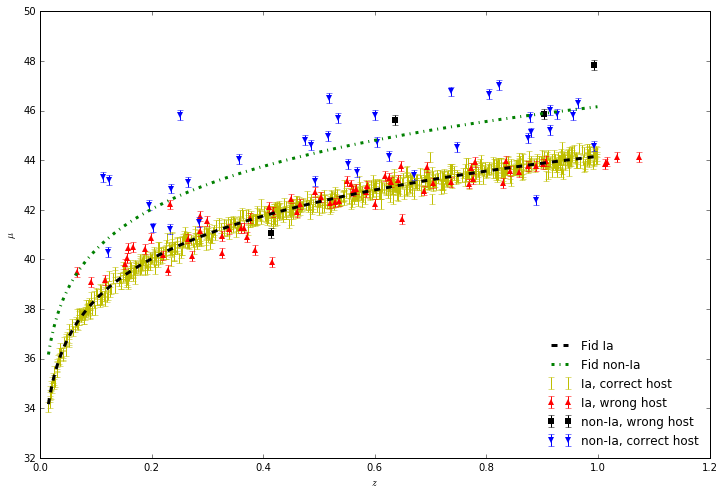

In [4]:
#example plot
plt.figure(figsize=(12,8))

plt.errorbar(z_b3_1[c_Ia],mu_o[c_Ia],yerr=[0.2*np.ones(len(c_Ia)),0.2*np.ones(len(c_Ia))],marker='',\
             label='Ia, correct host',ls='',color='y')
plt.errorbar(z_b3_1[w_Ia],mu_o[w_Ia],yerr=[0.2*np.ones(len(w_Ia)),0.2*np.ones(len(w_Ia))],marker='^',\
             label='Ia, wrong host',ls='',color='r',markeredgecolor = 'none')
plt.errorbar(z_b3_1[w_nIa],mu_o[w_nIa],yerr=[0.2*np.ones(len(w_nIa)),0.2*np.ones(len(w_nIa))],marker='s',\
             label='non-Ia, wrong host',ls='',color='k',markeredgecolor = 'none')
plt.errorbar(z_b3_1[c_nIa],mu_o[c_nIa],yerr=[0.2*np.ones(len(c_nIa)),0.2*np.ones(len(c_nIa))],marker='v',\
             label='non-Ia, correct host',ls='',color='b',markeredgecolor = 'none')
plt.plot(z,mu_t,'--k',label='Fid Ia',lw=3)
plt.plot(z,mu_t+2,'-.g',label='Fid non-Ia',lw=3)
plt.xlabel(r'$z$')
plt.ylabel(r'$\mu$')
plt.legend(loc=4,fontsize=12,frameon=False)
plt.show()

In [5]:
snetype=np.ones(N)
snetype[nIa]=0
cor_gal=np.ones(N)
cor_gal[w_gal]=0
np.savetxt('dataset_spectrcase.txt',np.c_[z,mu_t,z_b3_1,z_b3_2,mu_t,mu_o,snetype,cor_gal],fmt=['%2.3f']*6+['%1.f']*2,\
           header='\n'.join(["Average delta z %.2f" %0.1,"Error in mu %.2f for Ia and %.2f for nonaIa" %(0.2,1.5),\
                             "Type=1 for Ia, 0 otherwise","cor_z=1 if z_obs correct host, 0 otherwise",\
                             "z_correct mu_t z_obs z_shifted mu_o type cor_z"]))